<a href="https://colab.research.google.com/github/anfel-souissi/Machine-learning-projects/blob/main/FASI_PROJECT_%20A%20Deep%20Learning-Based%20Sensor%20Modeling%20for%20Smart%20Irrigation%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install scikeras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 38.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 886.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully unin

In [56]:
!pip install hyperopt


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll import scope
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Chargement du fichier et des Bibliothèques



In [25]:


uploaded = files.upload()

# Chargez le fichier CSV sélectionné
filename = list(uploaded.keys())[0]
data = pd.read_csv(io.BytesIO(uploaded[filename]))



Saving FASI- Project datasheet.csv to FASI- Project datasheet (2).csv


# Visualiser les caracteristique du dataset

In [26]:
data.head()
data.shape


(150, 7)

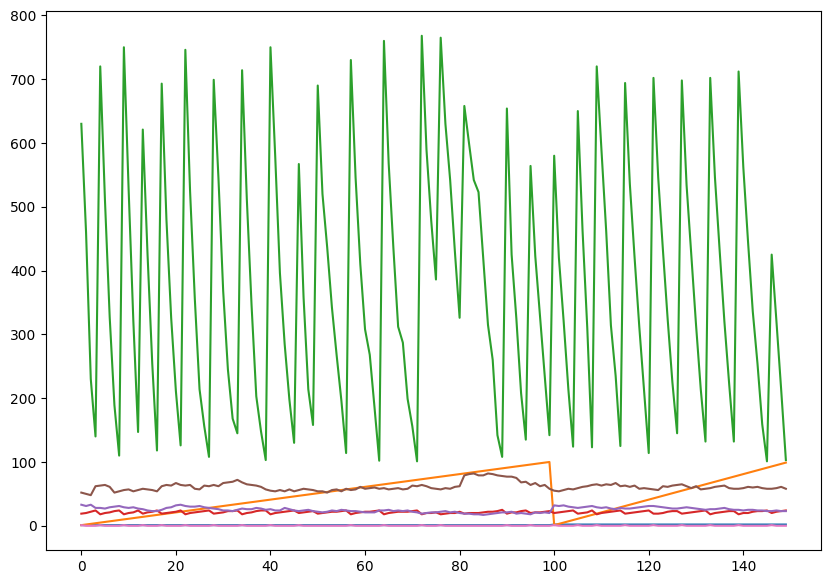

In [27]:
plt.figure(figsize=(10,7))
plt.plot(data)

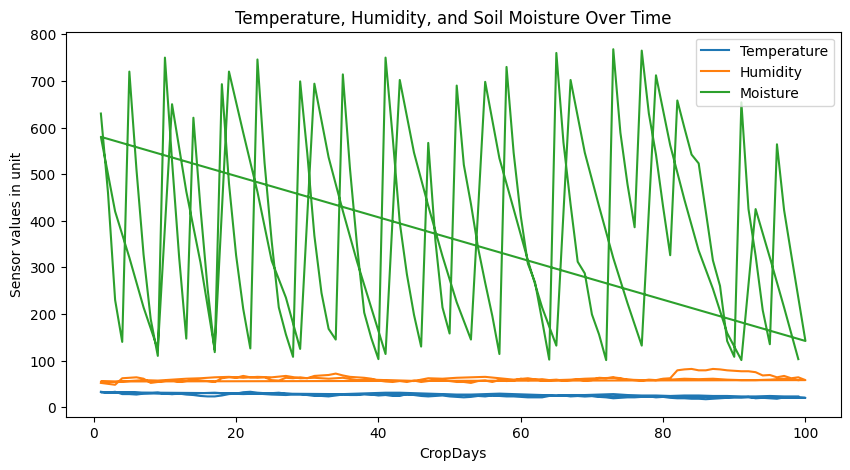

In [28]:

# Plotting
plt.figure(figsize=(10, 5))

# Plot Temperature
plt.plot(data['CropDays'], data['Temperature'], label='Temperature')

# Plot Humidity
plt.plot(data['CropDays'], data['Humidity'], label='Humidity')

# Plot Soil Moisture
plt.plot(data['CropDays'], data['Soil Moisture'], label='Moisture')

plt.xlabel('CropDays')
plt.ylabel('Sensor values in unit')
plt.legend()
plt.title('Temperature, Humidity, and Soil Moisture Over Time')
plt.show()


# Modelisation du LSTM

## 1.Préparation des Données

### 1.Interpoler les donnees avec lineaire (par defaut meilleure pour les series chronologique)

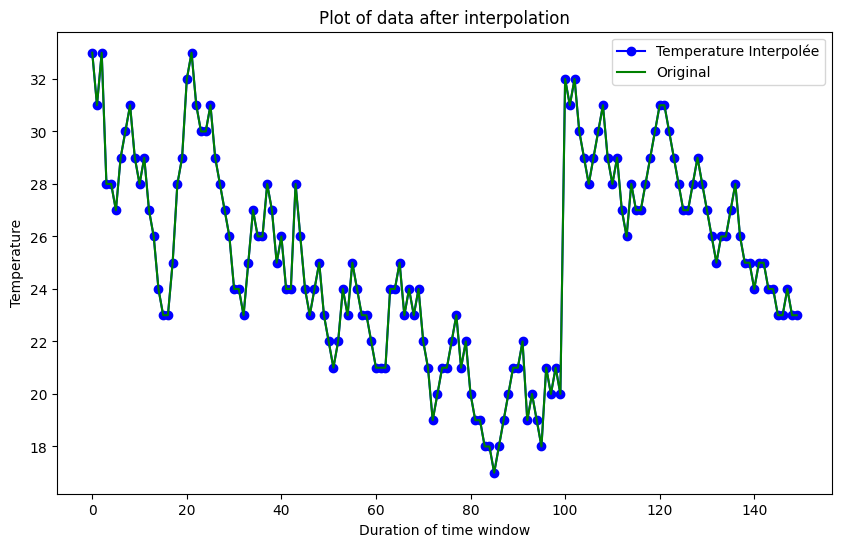

In [31]:
# Create a copy of the original data before interpolation
original_data = data.copy()

# Perform interpolation (you already have this step)
data['Temperature'] = data['Temperature'].interpolate()
data['Humidity'] = data['Humidity'].interpolate()
data['Soil Moisture'] = data['Soil Moisture'].interpolate()
data['Soil Temperature'] = data['Soil Temperature'].interpolate()

# Plotting the Temperature comparison
plt.figure(figsize=(10, 6))
plt.plot(data['Temperature'], marker='o', linestyle='-', color='b', label='Temperature Interpolée')
plt.plot(original_data.index, original_data['Temperature'], label='Original', color='green')
plt.xlabel('Duration of time window')
plt.ylabel('Temperature')
plt.legend()
plt.title('Plot of data after interpolation')
plt.show()

### 2.sélection de caractéristiques

In [32]:
# Préparation des données pour la sélection de caractéristiques
features = ['CropType','CropDays','Temperature', 'Humidity', 'Soil Moisture', 'Soil Temperature']
X = data[features]
y = data['Irrigation(Y/N)']

### 3.Normalisation des données

In [33]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Créer un DataFrame à partir des données mises à l'échelle
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Afficher les premières lignes des données mises à l'échelle
print(df_scaled.head())

   CropType  CropDays  Temperature  Humidity  Soil Moisture  Soil Temperature
0       0.0  0.000000       1.0000  0.117647       0.793103          0.142857
1       0.0  0.010101       0.8750  0.058824       0.538231          0.285714
2       0.0  0.020202       1.0000  0.000000       0.193403          0.571429
3       0.0  0.030303       0.6875  0.411765       0.058471          0.857143
4       0.0  0.040404       0.6875  0.441176       0.928036          0.000000


### 4.Application de Random forest pour la selection des attributs pertinents

In [36]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_scaled, y)

# Get feature names
feature_names = np.array(features)  # Replace 'features' with your actual feature names

# Print feature importances
print("Importances des caractéristiques:")
for i, importance in enumerate(rf.feature_importances_):
    print(f"{feature_names[i]}: {importance}")

# Select features based on importance
selector = SelectFromModel(rf, threshold='mean', prefit=True)
X_selected = selector.transform(X_scaled)
selected_features = selector.get_support(indices=True)
print("Caractéristiques sélectionnées:\n", np.array(features)[selected_features])

# Create a list of tuples (feature name, importance)
importance_list = list(zip(feature_names, rf.feature_importances_))

# Sort by importance (descending)
importance_list.sort(key=lambda x: x[1], reverse=True)

# Print the top three most important features
print("\n Trois premières caractéristiques pertinentes :")
for i in range(3):
    print(f"{importance_list[i][0]}: {importance_list[i][1]}")

Importances des caractéristiques:
CropType: 0.0009899789888441536
CropDays: 0.07632362522716117
Temperature: 0.034568152506123585
Humidity: 0.032501069141033026
Soil Moisture: 0.7927077041634235
Soil Temperature: 0.06290946997341447
Caractéristiques sélectionnées:
 ['Soil Moisture']

 Trois premières caractéristiques pertinentes :
Soil Moisture: 0.7927077041634235
CropDays: 0.07632362522716117
Soil Temperature: 0.06290946997341447


### 5.Mise à jour des données avec les caractéristiques sélectionnées

In [42]:
# Utiliser uniquement les caractéristiques
realfeatures = ['Soil Moisture', 'CropDays', 'Soil Temperature']
realdata_selected = data[realfeatures]
print(realdata_selected.head)

<bound method NDFrame.head of      Soil Moisture  CropDays  Soil Temperature
0              630         1                19
1              460         2                20
2              230         3                22
3              140         4                24
4              720         5                18
..             ...       ...               ...
145            101        91                24
146            425        93                20
147            321        95                22
148            214        97                23
149            103        99                24

[150 rows x 3 columns]>


In [40]:
# Utiliser uniquement les caractéristiques Soil Moisture, Temperature, et Humidity (comme l'article)
features = ['Temperature', 'Humidity', 'Soil Moisture']
data_selected = data[features]
print(data_selected.head)

<bound method NDFrame.head of      Temperature  Humidity  Soil Moisture
0             33        52            630
1             31        50            460
2             33        48            230
3             28        62            140
4             28        63            720
..           ...       ...            ...
145           23        58            101
146           23        58            425
147           24        59            321
148           23        61            214
149           23        58            103

[150 rows x 3 columns]>


### 6.Entrainement de modele (Séparer les données par type de culture)


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



100%|██████████| 20/20 [02:24<00:00,  7.20s/trial, best loss: 0.05825034901499748]
Meilleurs hyperparamètres trouvés pour 1:
{'batch_size': 30.0, 'epochs': 40.0, 'learning_rate': 0.003948750076380121, 'lstm_units': 120.0}
Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 849ms/step - loss: 0.1574 - val_loss: 0.3372
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.3060 - val_loss: 0.1565
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0869 - val_loss: 0.1213
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0730 - val_loss: 0.0993
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0547 - val_loss: 0.0969
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0548 - val_loss: 0.1062
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0509 - val_loss: 0.0974
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0532 - val_loss: 0.0938
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0502 - val_loss: 0.0812
Epoch 10/40
2/2 ━━━━━━━━━━━━

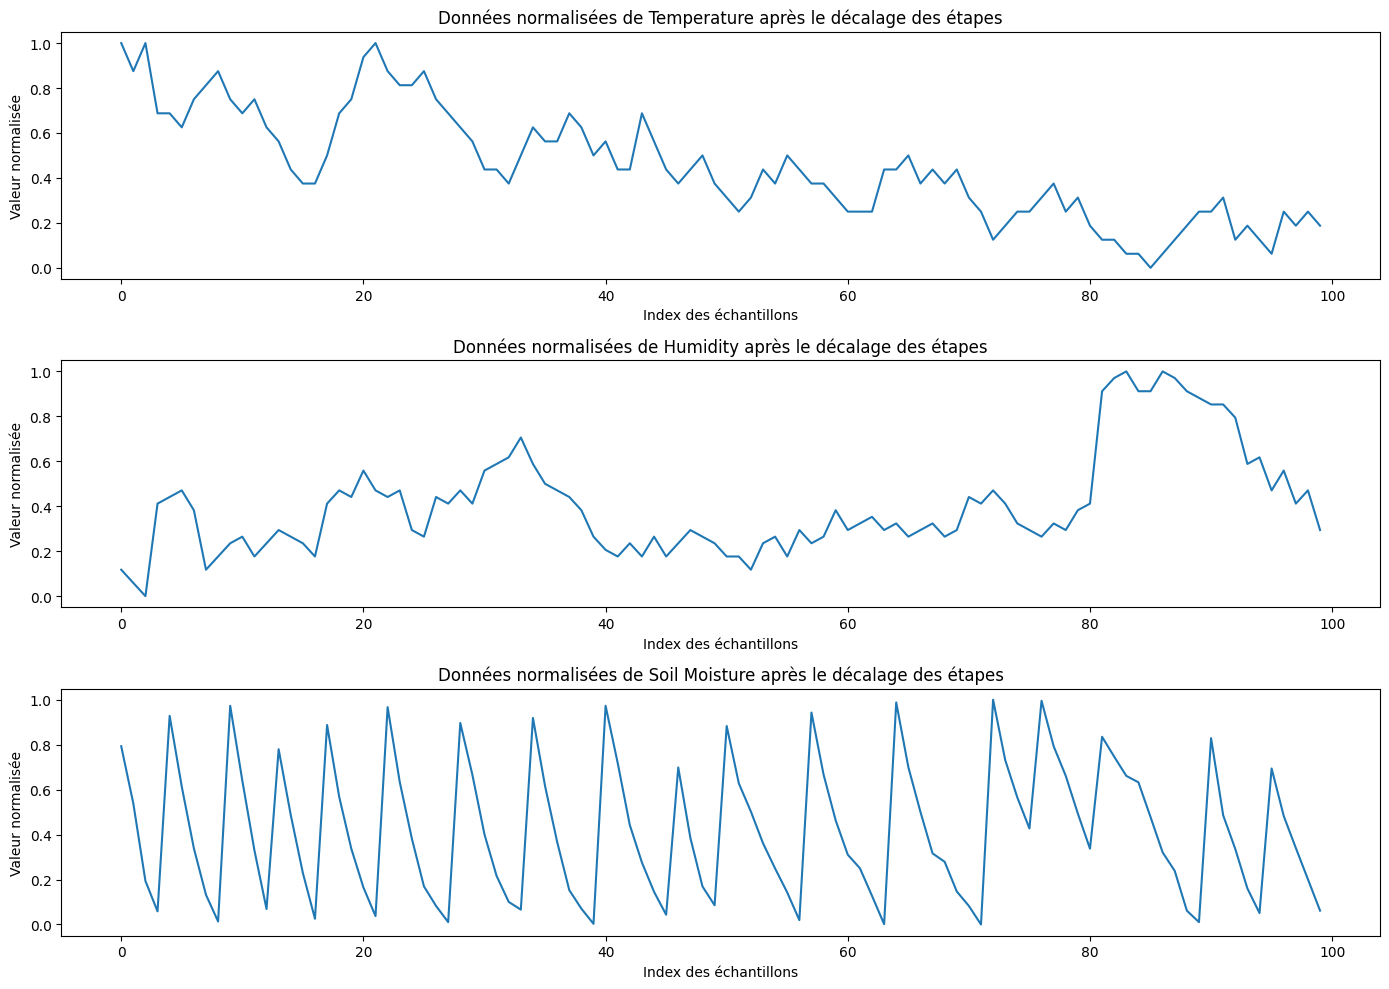

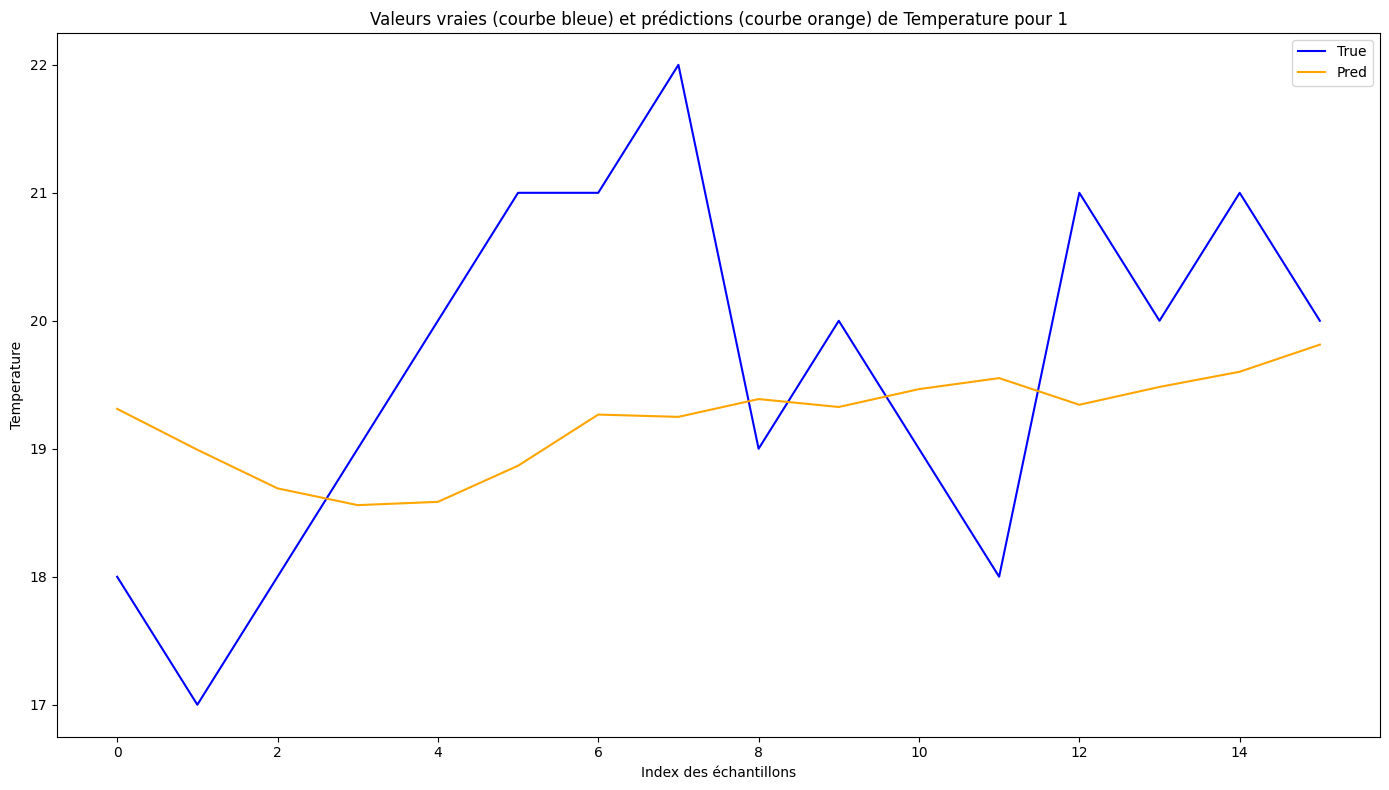

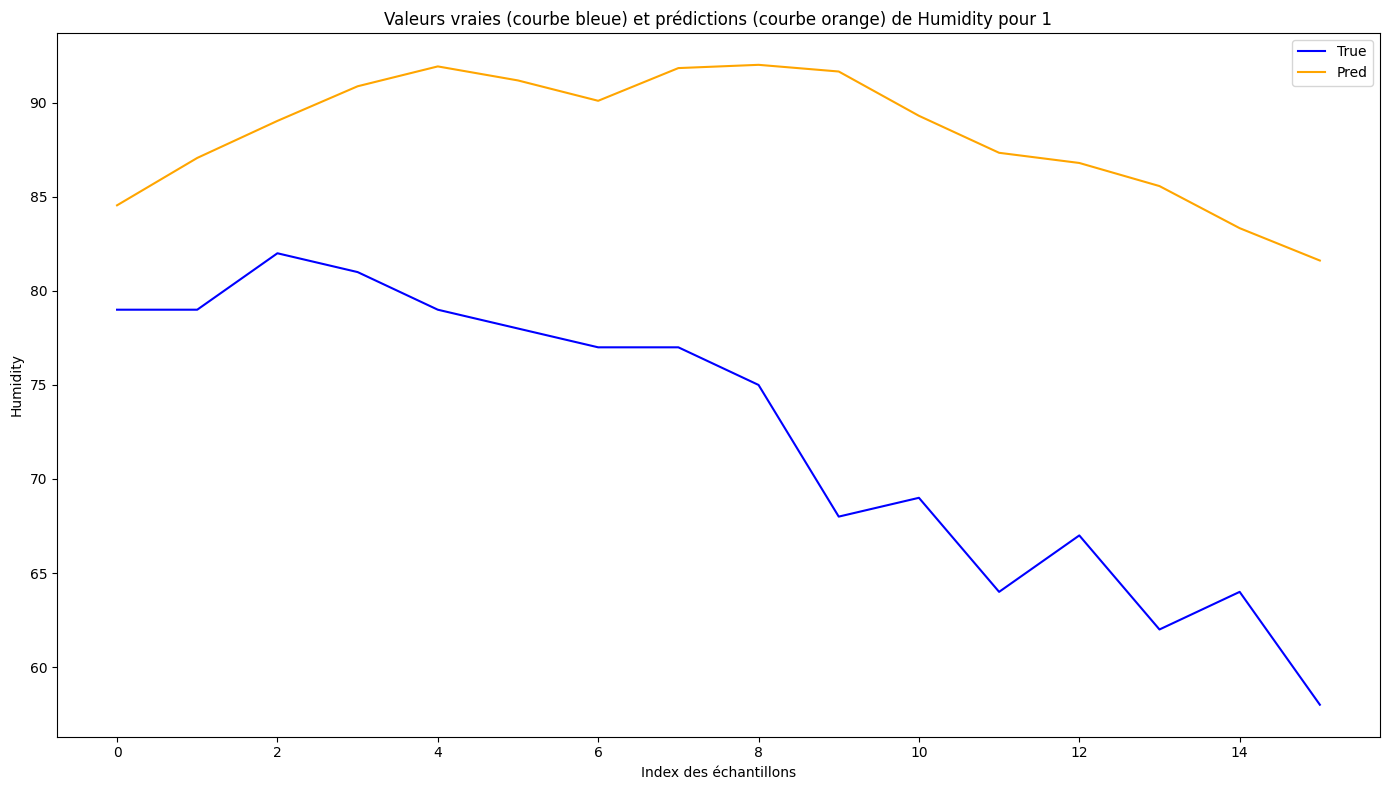

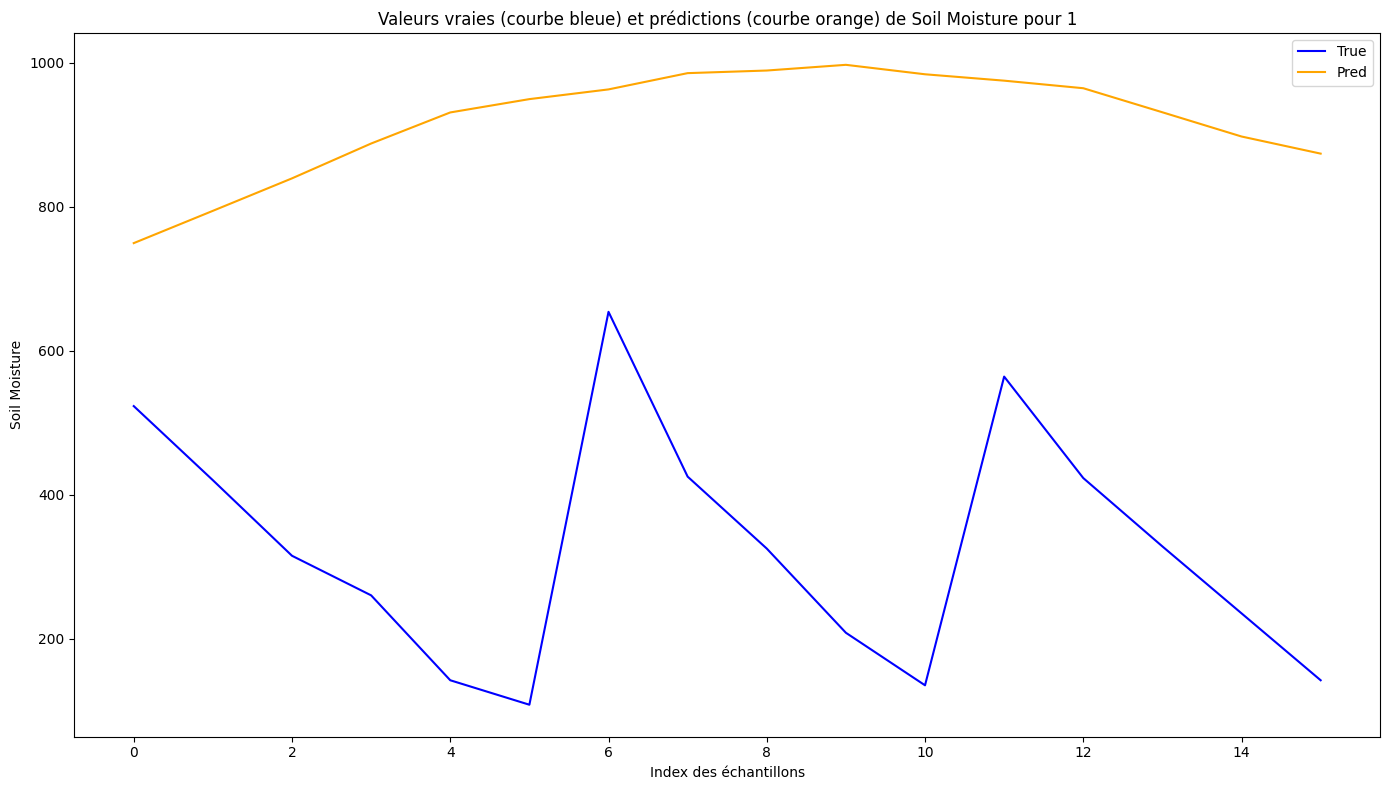

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



100%|██████████| 20/20 [01:51<00:00,  5.58s/trial, best loss: 0.02964824251830578]
Meilleurs hyperparamètres trouvés pour 2:
{'batch_size': 20.0, 'epochs': 40.0, 'learning_rate': 0.036517119173784945, 'lstm_units': 120.0}
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2810 - val_loss: 5412842635264.0000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 6613997977600.0000 - val_loss: 453094146048.0000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 527173156864.0000 - val_loss: 123763490816.0000
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 151831740416.0000 - val_loss: 0.0621
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2158 - val_loss: 0.0290
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0738 - val_loss: 444568064.0000
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 647655104.0000 - val_loss: 0.0710
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2596 - val_loss: 0.0709
Epoch 9/40
1/1 ━━━━━━━━━━━━━

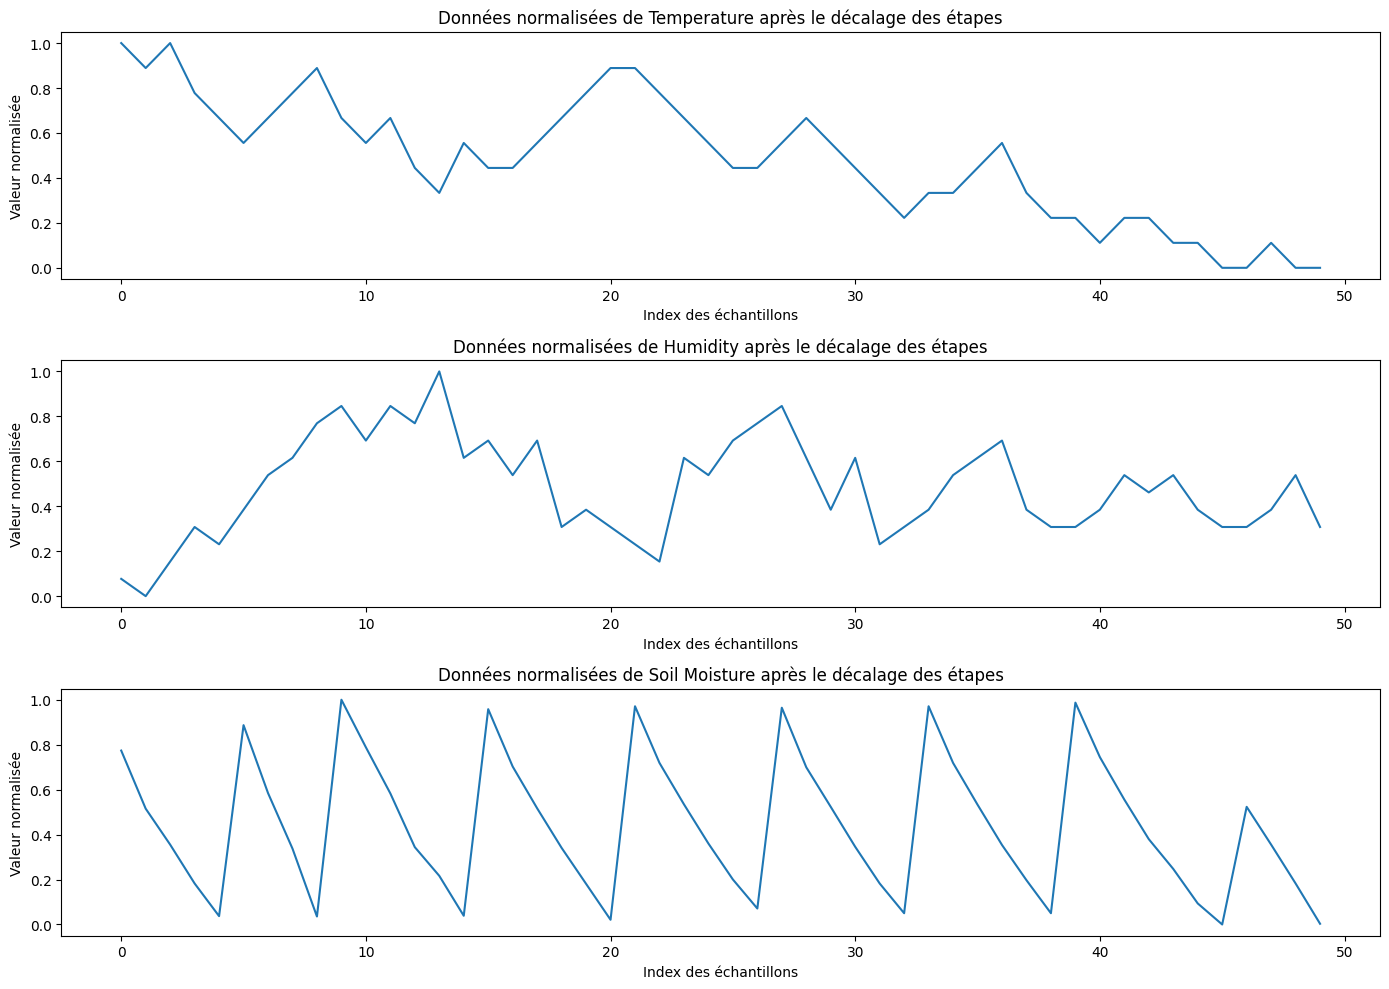

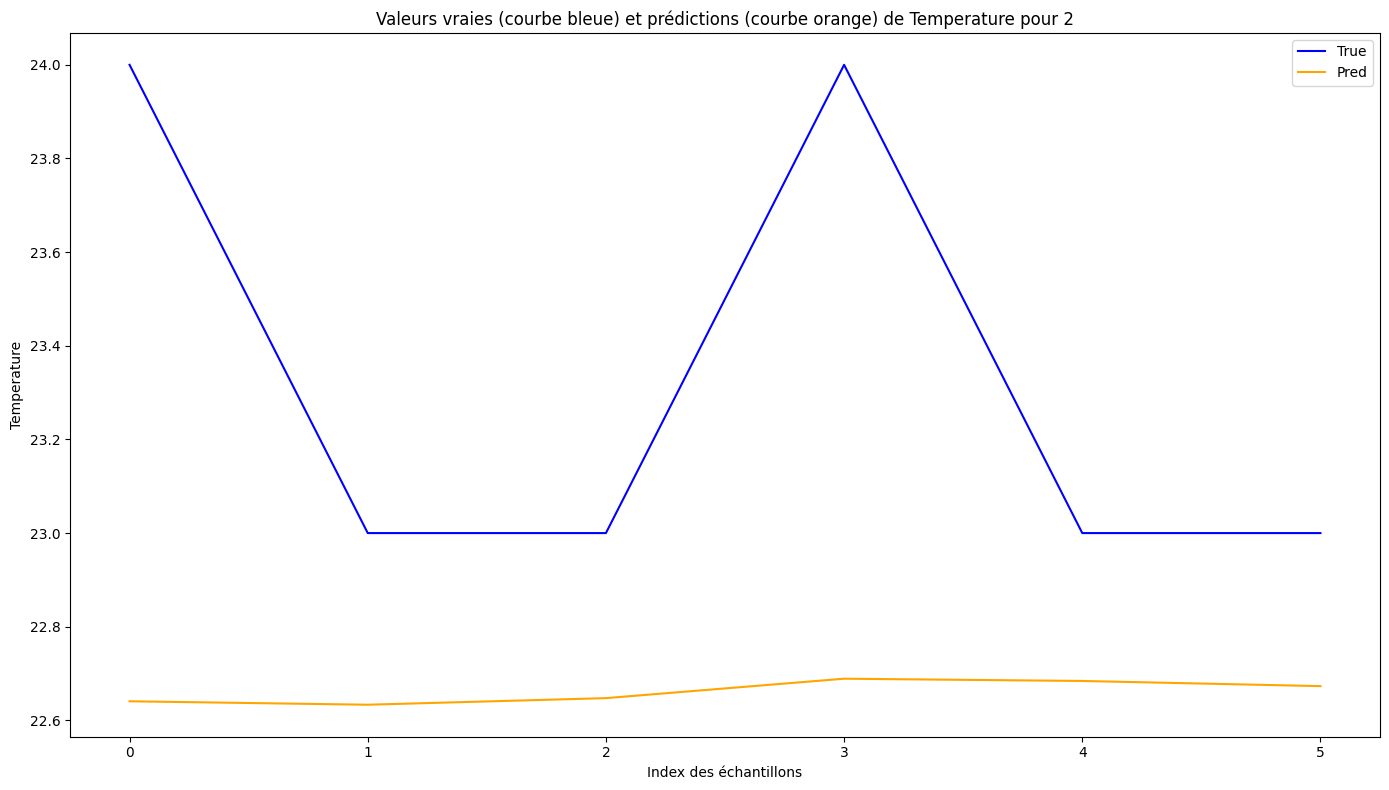

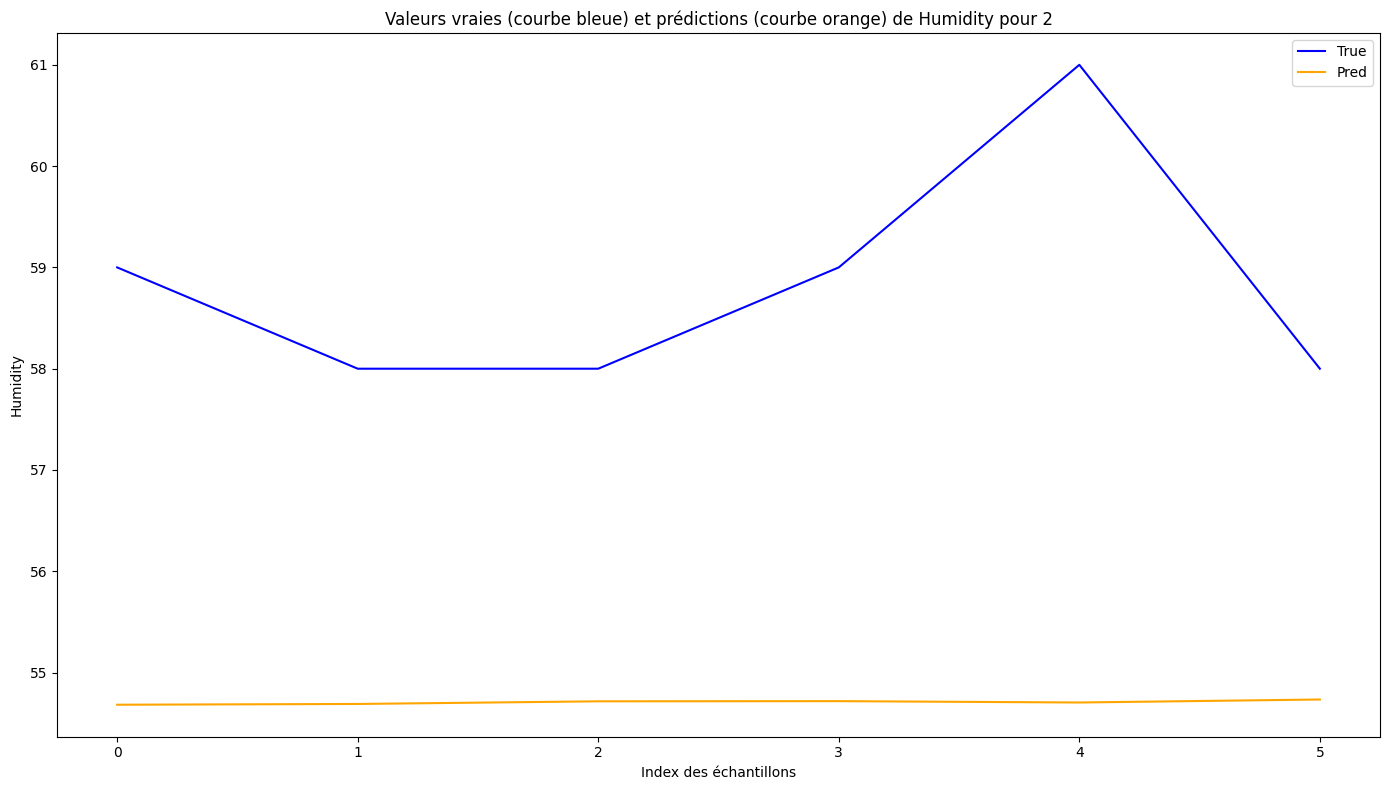

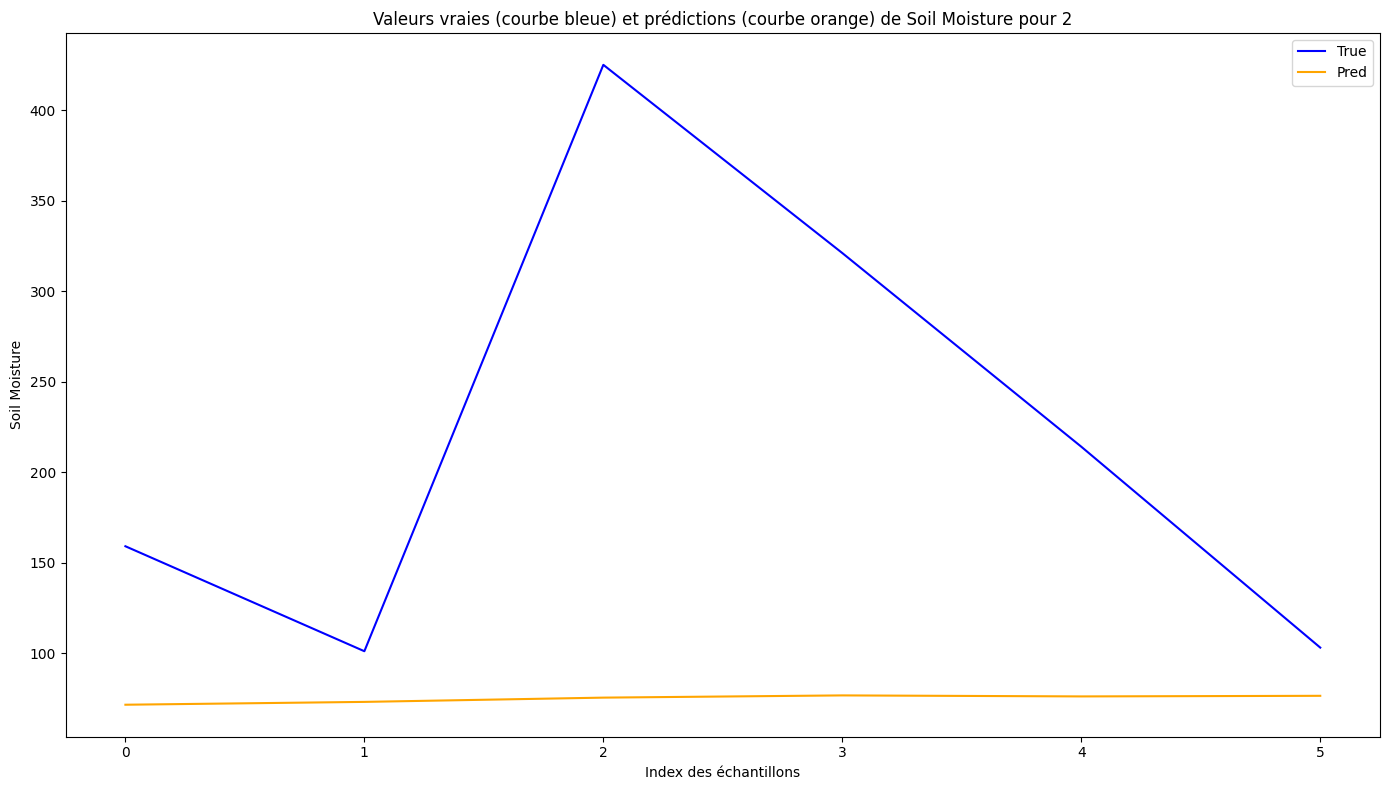

In [75]:
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour créer et évaluer le modèle avec les hyperparamètres spécifiés
def create_and_evaluate_model(params):
    lstm_units = int(params['lstm_units'])
    learning_rate = params['learning_rate']
    batch_size = int(params['batch_size'])
    epochs = int(params['epochs'])

    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=(seq_length, X_train.shape[2])))
    model.add(Dense(X_train.shape[2]))  # Couche de sortie adaptée à votre problème
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')  # Utilisation de MSE pour une régression

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)

    return {'loss': loss, 'status': 'ok'}

# Liste des types de culture uniques
crop_types = data['CropType'].unique()

# Boucle sur chaque type de culture
for crop_type in crop_types:
    crop_data = data[data['CropType'] == crop_type]
    crop_data.set_index('CropDays', inplace=True)

    # Préparation des données pour le modèle LSTM
    features = ['Temperature', 'Humidity', 'Soil Moisture']
    values = crop_data[features].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values)

    # Fonction pour créer des séquences pour l'entrée LSTM
    def create_sequences(data, seq_length=24):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    seq_length = 24
    X, y = create_sequences(scaled_data, seq_length)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Définition de l'objet Trials pour stocker les résultats de l'optimisation
    trials = Trials()

    # Définition de l'espace des hyperparamètres à rechercher avec Hyperopt
    space = {
        'lstm_units': hp.quniform('lstm_units', 50, 150, 10),  # Units in LSTM layer
        'batch_size': hp.quniform('batch_size', 10, 30, 10),    # Batch size
        'epochs': hp.quniform('epochs', 20, 50, 10),            # Number of epochs
        'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1))  # Learning rate
    }

    # Recherche des meilleurs hyperparamètres avec Hyperopt
    best = fmin(create_and_evaluate_model, space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Affichage des meilleurs résultats
    print(f"Meilleurs hyperparamètres trouvés pour {crop_type}:")
    print(best)

    # Utilisation des meilleurs hyperparamètres pour créer et entraîner le modèle final
    best_params = space_eval(space, best)
    model = Sequential()
    model.add(LSTM(int(best_params['lstm_units']), activation='relu', input_shape=(seq_length, X_train.shape[2])))
    model.add(Dense(X_train.shape[2]))  # Couche de sortie adaptée à votre problème
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')  # Utilisation de MSE pour une régression

    history = model.fit(X_train, y_train, epochs=int(best_params['epochs']), batch_size=int(best_params['batch_size']), validation_data=(X_test, y_test), verbose=1)

    # Évaluation du modèle sur les données de test
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Loss (MSE) sur les données de test: {loss}")

    # Prédictions sur les données de test
    y_pred = model.predict(X_test)

    # Transformation inverse des prédictions et des valeurs réelles pour obtenir l'échelle d'origine
    y_pred_inverse = scaler.inverse_transform(y_pred)
    y_test_inverse = scaler.inverse_transform(y_test)


    # Calcul des métriques pour chaque caractéristique
    mse = mean_squared_error(y_test_inverse, y_pred_inverse, multioutput='raw_values')
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse, multioutput='raw_values')
    r2 = r2_score(y_test_inverse, y_pred_inverse, multioutput='raw_values')

    # Affichage des métriques
    for i, characteristic in enumerate(features):
        print(f"Metrics for {characteristic}:")
        print(f"   MSE: {mse[i]}")
        print(f"   MAE: {mae[i]}")
        print(f"   R-squared: {r2[i]}")


         # Visualisation des données normalisées après le décalage des étapes
    plt.figure(figsize=(14, 10))

    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i+1)
        plt.plot(range(len(scaled_data)), scaled_data[:, i], label=f'{feature} (normalized)')
        plt.xlabel('Index des échantillons')
        plt.ylabel('Valeur normalisée')
        plt.title(f'Données normalisées de {feature} après le décalage des étapes')

    plt.tight_layout()
    plt.show()

    # Visualisation des résultats (par exemple, les quatre caractéristiques)
    characteristics = ['Temperature', 'Humidity', 'Soil Moisture']
    for i, characteristic in enumerate(characteristics):
        plt.figure(figsize=(14, 8))

        # Valeurs vraies vs prédictions
        plt.plot(range(len(y_test_inverse)), y_test_inverse[:, i], color='blue', label='True')
        plt.plot(range(len(y_pred_inverse)), y_pred_inverse[:, i], color='orange', label='Pred')

        plt.title(f'Valeurs vraies (courbe bleue) et prédictions (courbe orange) de {characteristic} pour {crop_type}')
        plt.xlabel('Index des échantillons')
        plt.ylabel(characteristic)
        plt.legend()
        plt.tight_layout()
        plt.show()

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



100%|██████████| 20/20 [02:34<00:00,  7.72s/trial, best loss: 0.05510430037975311]
Meilleurs hyperparamètres trouvés pour 1:
{'batch_size': 20.0, 'epochs': 50.0, 'learning_rate': 0.016148711746626573, 'lstm_units': 90.0}
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 5.1302 - val_loss: 0.3120
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1808 - val_loss: 0.2057
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1361 - val_loss: 0.2427
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1329 - val_loss: 0.1284
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0771 - val_loss: 0.1073
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0758 - val_loss: 0.0629
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0629 - val_loss: 0.0639
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0614 - val_loss: 0.1334
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0741 - val_loss: 0.0772
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━

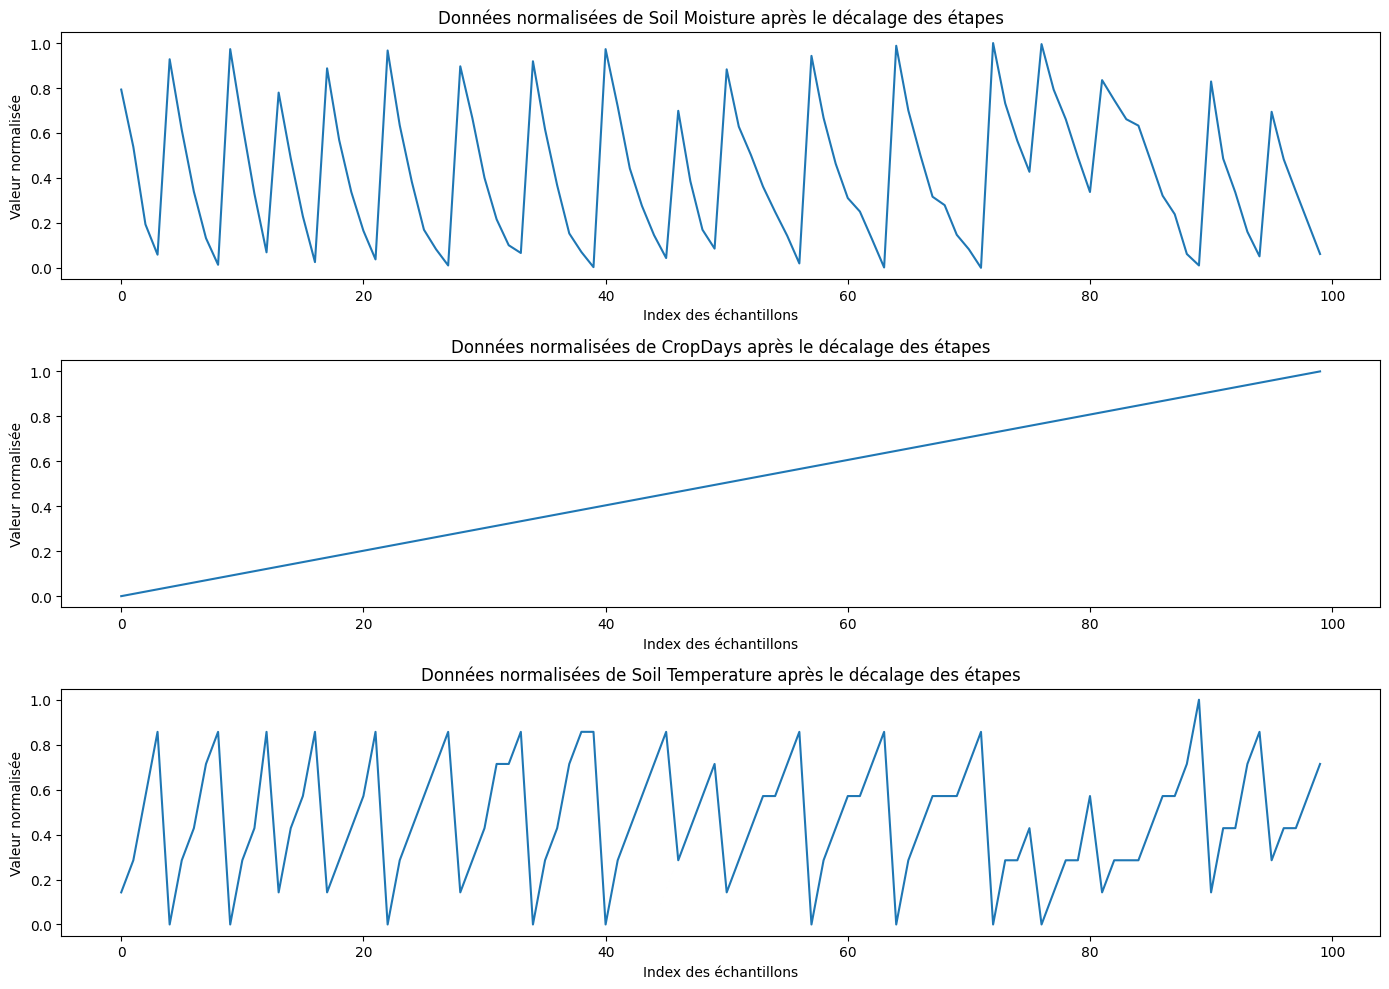

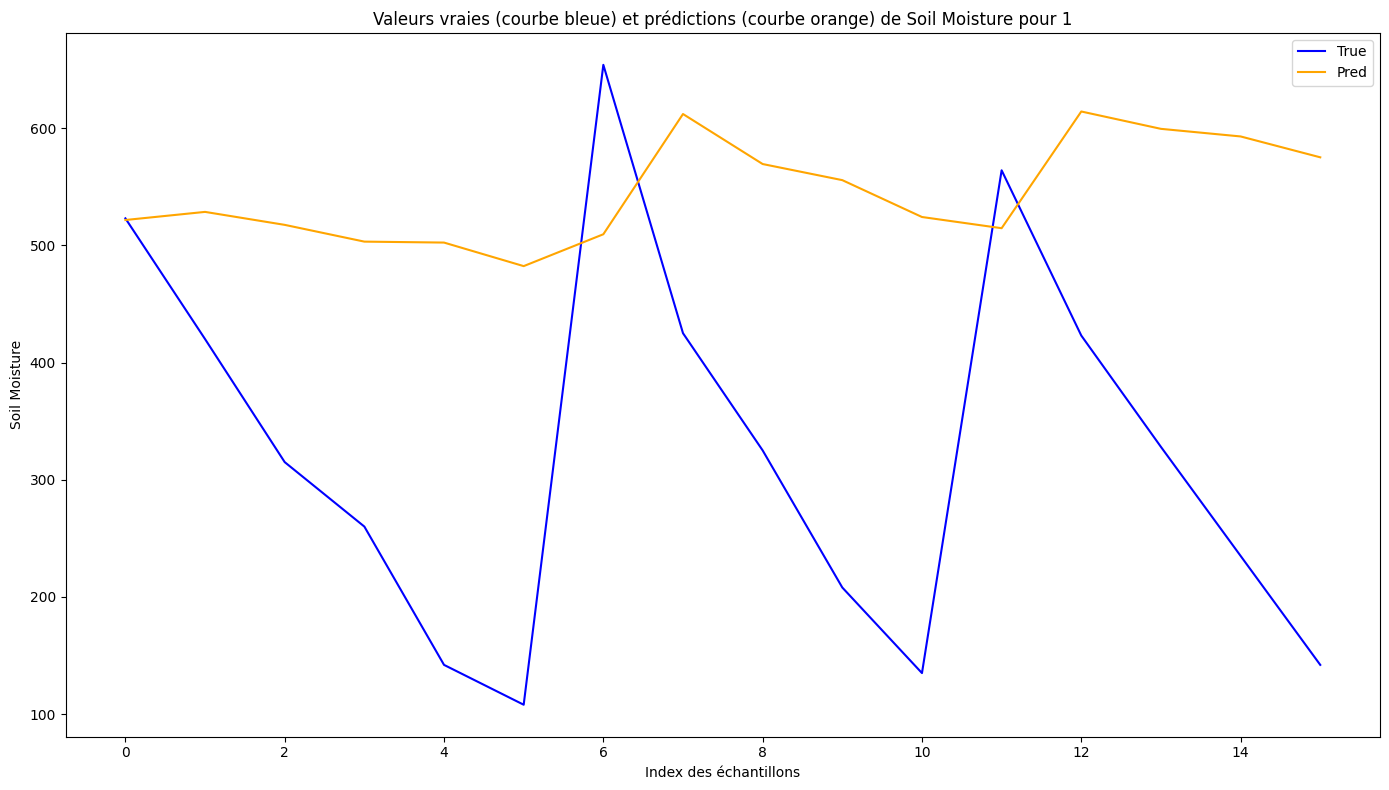

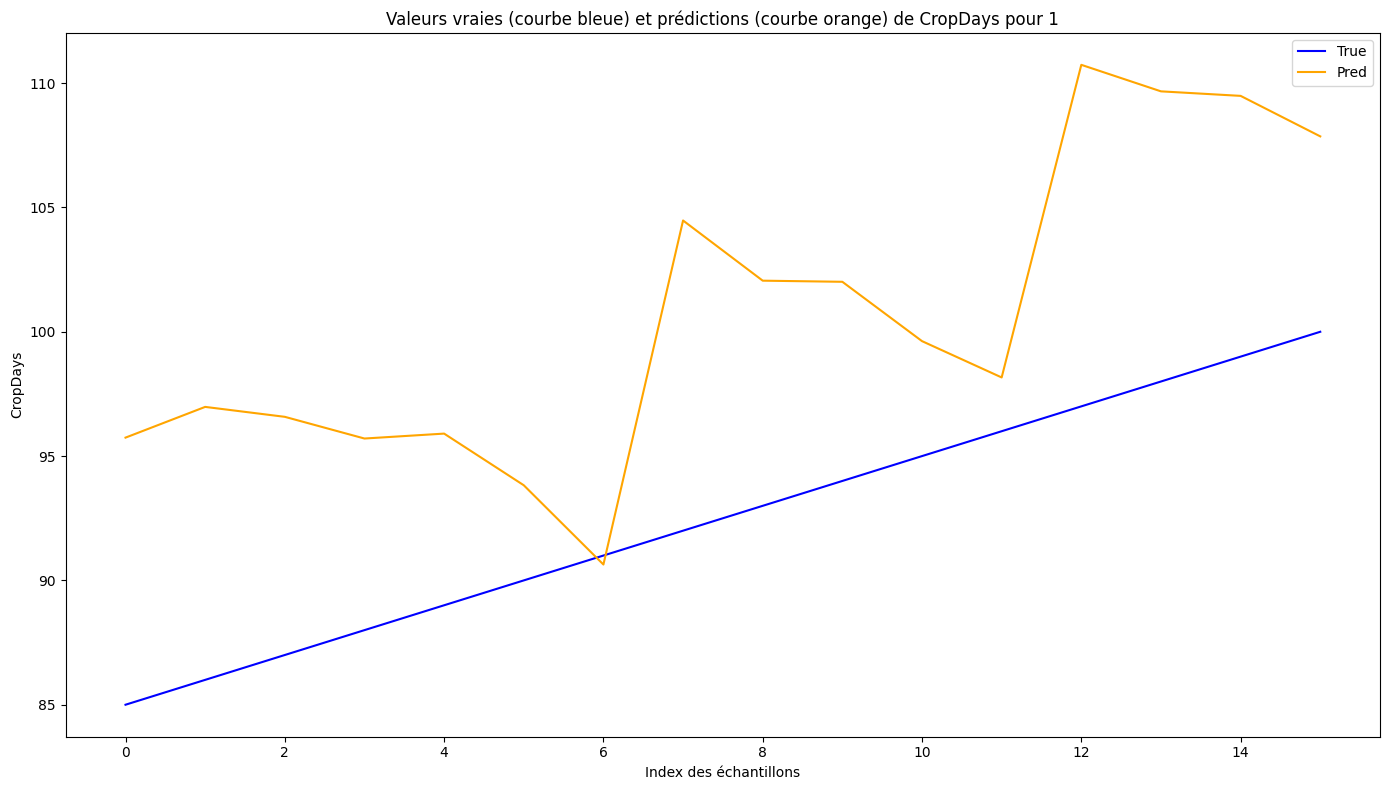

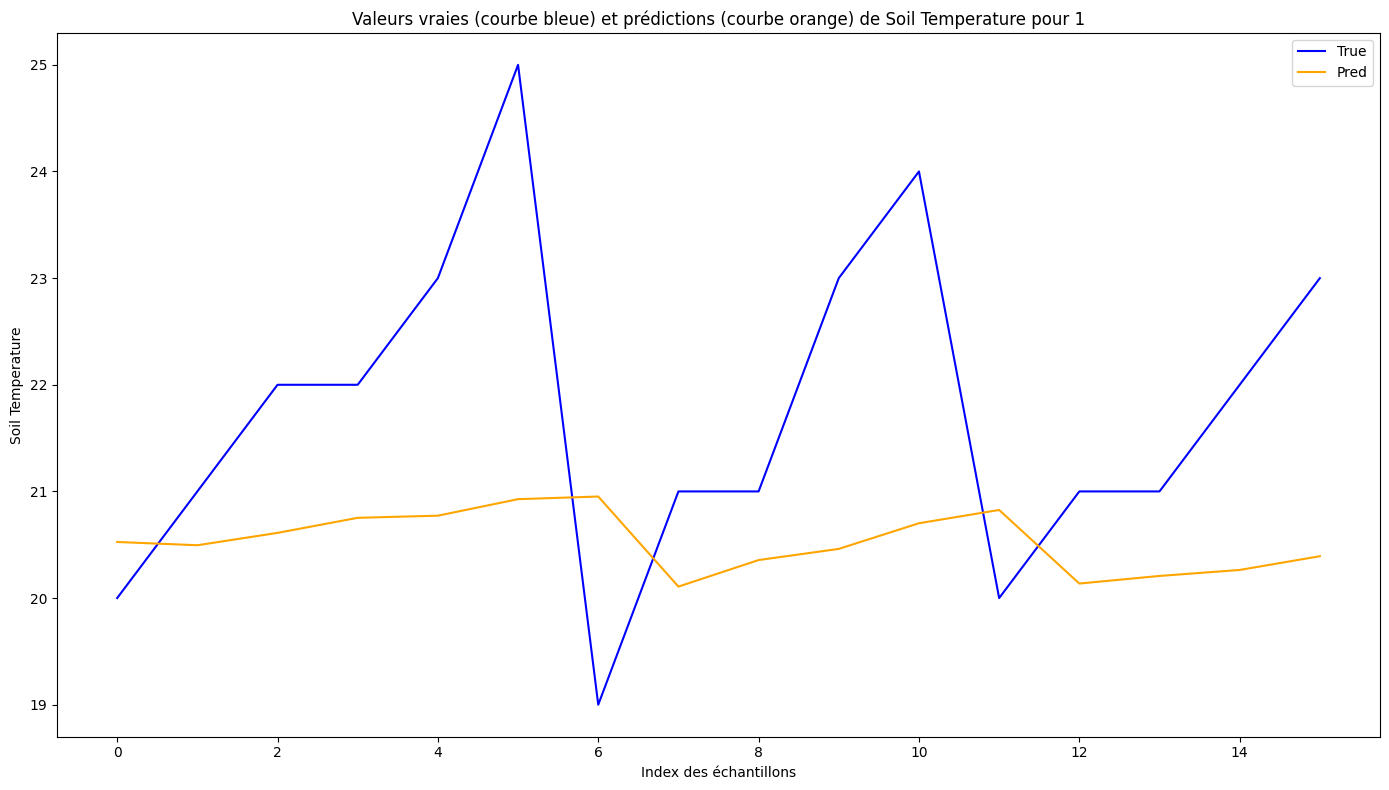

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



100%|██████████| 20/20 [01:59<00:00,  5.97s/trial, best loss: 0.08102507144212723]
Meilleurs hyperparamètres trouvés pour 2:
{'batch_size': 20.0, 'epochs': 40.0, 'learning_rate': 0.017178203077231967, 'lstm_units': 70.0}
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4023 - val_loss: 35.8150
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 17.9736 - val_loss: 0.6965
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.5521 - val_loss: 0.4528
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.3427 - val_loss: 0.4127
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3109 - val_loss: 0.3840
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2859 - val_loss: 0.3608
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2653 - val_loss: 0.3353
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2447 - val_loss: 0.2995
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2184 - val_loss: 0.2285
Epoch 10/40
1/1 ━━━━━━━━━━

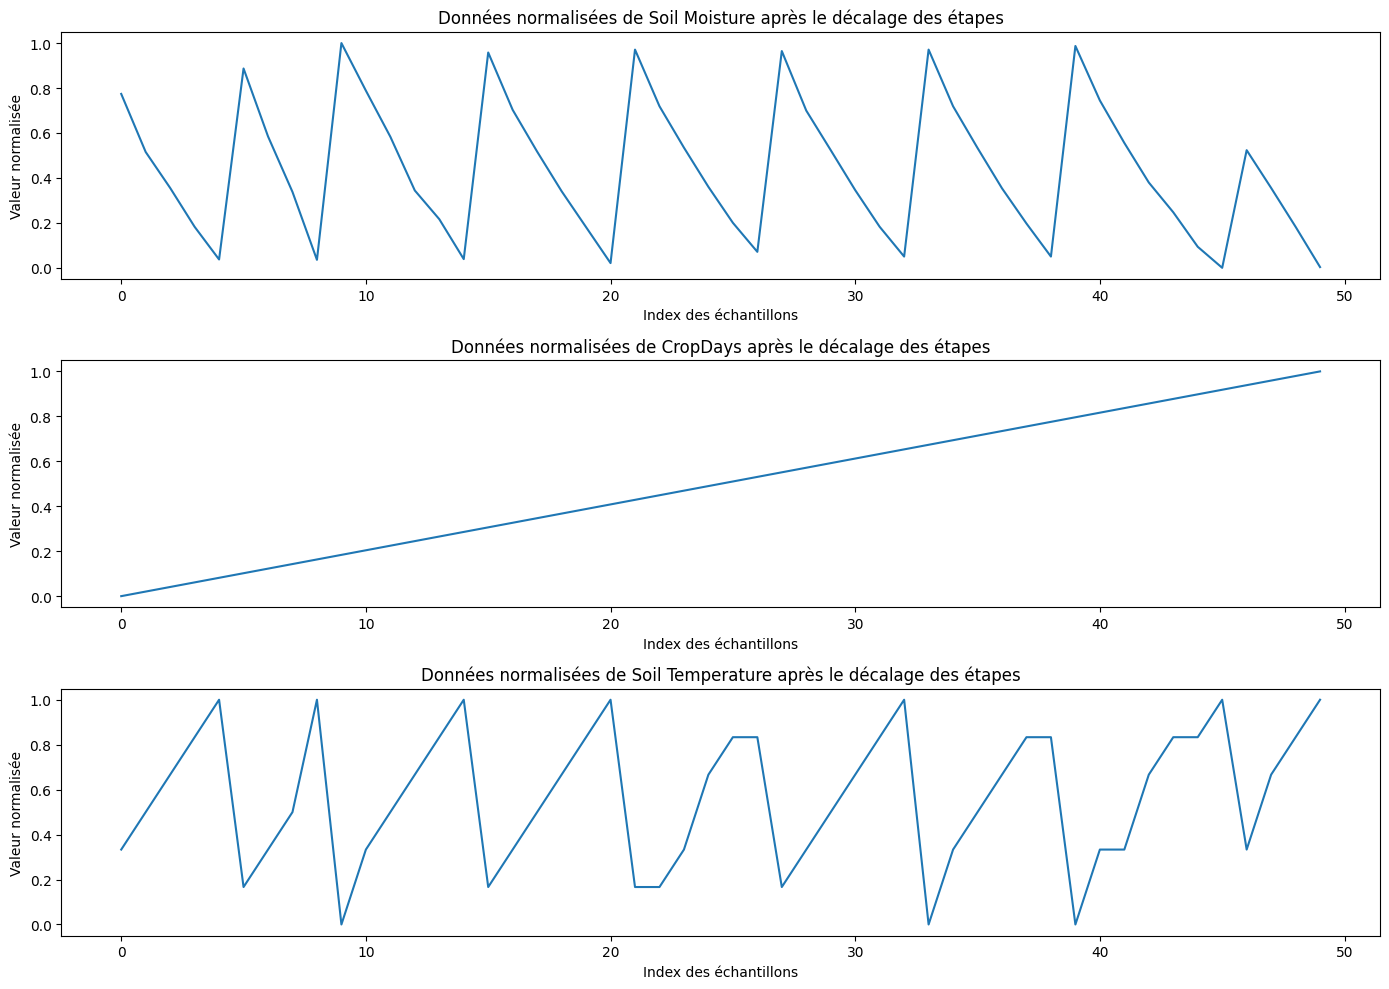

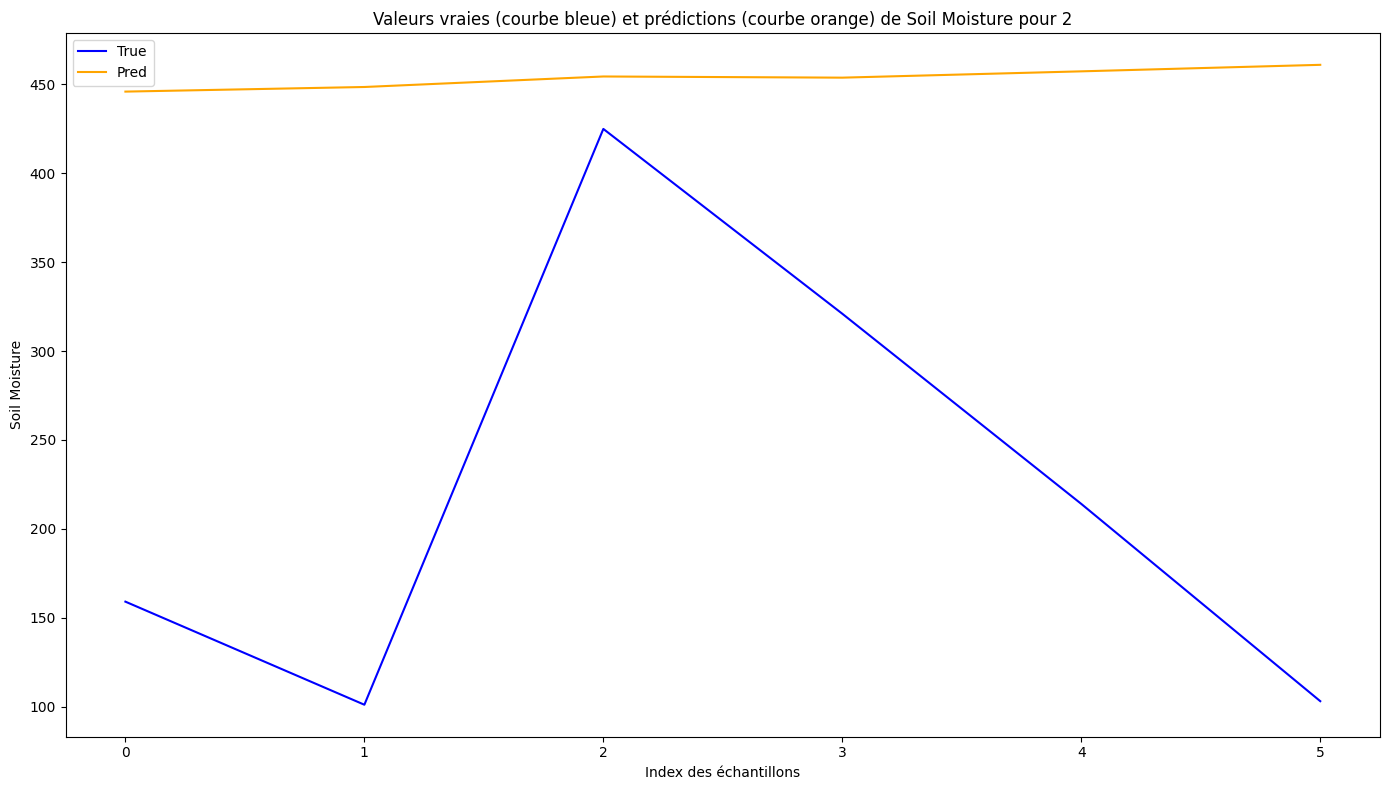

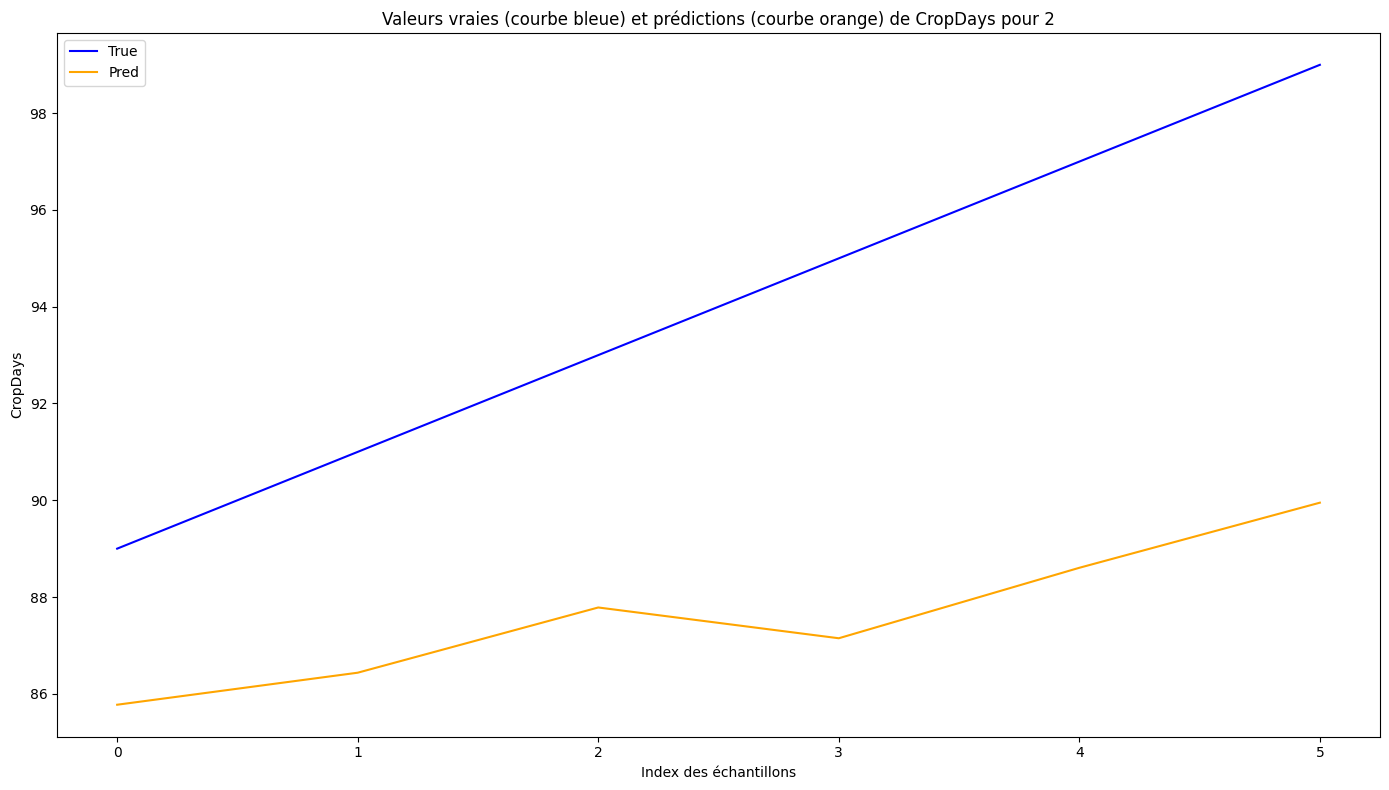

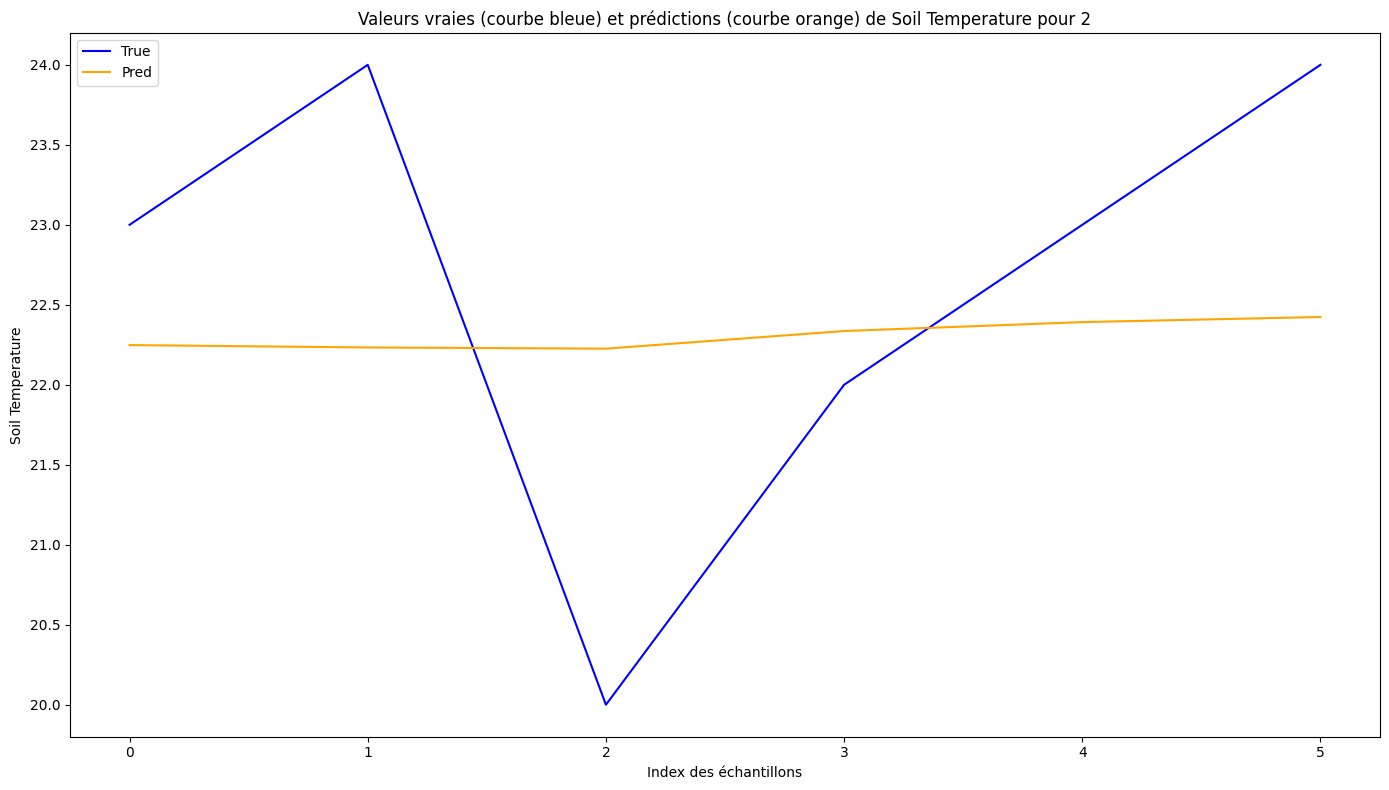

In [76]:
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Fonction pour créer et évaluer le modèle avec les hyperparamètres spécifiés
def create_and_evaluate_model(params):
    lstm_units = int(params['lstm_units'])
    learning_rate = params['learning_rate']
    batch_size = int(params['batch_size'])
    epochs = int(params['epochs'])

    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=(seq_length, X_train.shape[2])))
    model.add(Dense(X_train.shape[2]))  # Couche de sortie adaptée à votre problème
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')  # Utilisation de MSE pour une régression

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)

    return {'loss': loss, 'status': 'ok'}

# Liste des types de culture uniques
crop_types = data['CropType'].unique()

# Boucle sur chaque type de culture
for crop_type in crop_types:
    crop_data = data[data['CropType'] == crop_type].copy()  # Filtrer les données pour le type de culture spécifique

    # Préparation des données pour le modèle LSTM
    features = ['Soil Moisture', 'CropDays', 'Soil Temperature']
    values = crop_data[features].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values)

    # Fonction pour créer des séquences pour l'entrée LSTM
    def create_sequences(data, seq_length=24):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    seq_length = 24
    X, y = create_sequences(scaled_data, seq_length)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Définition de l'objet Trials pour stocker les résultats de l'optimisation
    trials = Trials()

    # Définition de l'espace des hyperparamètres à rechercher avec Hyperopt
    space = {
        'lstm_units': hp.quniform('lstm_units', 50, 150, 10),  # Units in LSTM layer
        'batch_size': hp.quniform('batch_size', 10, 30, 10),    # Batch size
        'epochs': hp.quniform('epochs', 20, 50, 10),            # Number of epochs
        'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1))  # Learning rate
    }

    # Recherche des meilleurs hyperparamètres avec Hyperopt
    best = fmin(create_and_evaluate_model, space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Affichage des meilleurs résultats
    print(f"Meilleurs hyperparamètres trouvés pour {crop_type}:")
    print(best)

    # Utilisation des meilleurs hyperparamètres pour créer et entraîner le modèle final
    best_params = space_eval(space, best)
    model = Sequential()
    model.add(LSTM(int(best_params['lstm_units']), activation='relu', input_shape=(seq_length, X_train.shape[2])))
    model.add(Dense(X_train.shape[2]))  # Couche de sortie adaptée à votre problème
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')  # Utilisation de MSE pour une régression

    history = model.fit(X_train, y_train, epochs=int(best_params['epochs']), batch_size=int(best_params['batch_size']), validation_data=(X_test, y_test), verbose=1)

    # Évaluation du modèle sur les données de test
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Loss (MSE) sur les données de test: {loss}")

    # Prédictions sur les données de test
    y_pred = model.predict(X_test)

    # Transformation inverse des prédictions et des valeurs réelles pour obtenir l'échelle d'origine
    y_pred_inverse = scaler.inverse_transform(y_pred)
    y_test_inverse = scaler.inverse_transform(y_test)


    # Calcul des métriques pour chaque caractéristique
    mse = mean_squared_error(y_test_inverse, y_pred_inverse, multioutput='raw_values')
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse, multioutput='raw_values')
    r2 = r2_score(y_test_inverse, y_pred_inverse, multioutput='raw_values')

    # Affichage des métriques
    for i, characteristic in enumerate(features):
        print(f"Metrics for {characteristic}:")
        print(f"   MSE: {mse[i]}")
        print(f"   MAE: {mae[i]}")
        print(f"   R-squared: {r2[i]}")


         # Visualisation des données normalisées après le décalage des étapes
    plt.figure(figsize=(14, 10))

    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i+1)
        plt.plot(range(len(scaled_data)), scaled_data[:, i], label=f'{feature} (normalized)')
        plt.xlabel('Index des échantillons')
        plt.ylabel('Valeur normalisée')
        plt.title(f'Données normalisées de {feature} après le décalage des étapes')

    plt.tight_layout()
    plt.show()

    # Visualisation des résultats (par exemple, les quatre caractéristiques)
    characteristics = ['Soil Moisture', 'CropDays', 'Soil Temperature']
    for i, characteristic in enumerate(characteristics):
        plt.figure(figsize=(14, 8))

        # Valeurs vraies vs prédictions
        plt.plot(range(len(y_test_inverse)), y_test_inverse[:, i], color='blue', label='True')
        plt.plot(range(len(y_pred_inverse)), y_pred_inverse[:, i], color='orange', label='Pred')

        plt.title(f'Valeurs vraies (courbe bleue) et prédictions (courbe orange) de {characteristic} pour {crop_type}')
        plt.xlabel('Index des échantillons')
        plt.ylabel(characteristic)
        plt.legend()
        plt.tight_layout()
        plt.show()


## Evaluation

Pour évaluer un modèle de régression comme celui que vous avez entraîné avec un LSTM pour prédire des caractéristiques telles que 'Soil Moisture', 'Soil Temperature', 'Temperature', et 'Humidity', l'accuracy n'est pas la métrique appropriée car elle est utilisée principalement pour les problèmes de classification. Pour les modèles de régression, nous allons plutôt utiliser des métriques telles que l'erreur quadratique moyenne (Mean Squared Error, MSE), l'erreur absolue moyenne (Mean Absolute Error, MAE), et d'autres métriques comme le coefficient de détermination (R-squared).

Température :
MSE (Mean Squared Error) : 1.98
Les prédictions du modèle pour la température ont une erreur quadratique moyenne de 1.98, ce qui indique une précision raisonnable mais avec de la place pour l'amélioration.
MAE (Mean Absolute Error) : 1.21
L'erreur absolue moyenne est de 1.21 degrés Celsius, ce qui montre que les prédictions sont généralement à moins de 1.21 degré de la valeur réelle de la température.
R-squared : -0.07
Le coefficient de détermination R² est négatif, ce qui signifie que le modèle ne parvient pas à expliquer la variance de la température à partir des données d'entrée. Cela suggère que le modèle actuel pourrait ne pas être bien adapté aux fluctuations de la température.
Humidité :
MSE : 291.38
Les prédictions pour l'humidité ont un MSE élevé de 291.38, indiquant que le modèle a du mal à prédire avec précision les niveaux d'humidité.
MAE : 15.95
L'erreur absolue moyenne est de 15.95, montrant que les prédictions peuvent être éloignées de presque 16 unités de la véritable valeur d'humidité.
R-squared : -4.22
Le R² négatif souligne que le modèle ne parvient pas à capturer la variation de l'humidité à partir des variables en entrée. Cela pourrait indiquer des informations manquantes ou des relations complexes non modélisées.
Humidité du Sol :
MSE : 386770.40
Le MSE est extrêmement élevé pour l'humidité du sol, ce qui montre que les prédictions sont très éloignées des valeurs réelles.
MAE : 594.21
L'erreur absolue moyenne est très élevée à 594.21, indiquant des prédictions qui peuvent être éloignées de 594.21 unités de la véritable humidité du sol.
R-squared : -14.11
Le R² très négatif suggère que le modèle ne parvient pas du tout à expliquer la variance de l'humidité du sol à partir des variables d'entrée. Cela soulève des préoccupations sérieuses quant à l'adéquation du modèle pour ce type de prévision.
Conclusion :
Le modèle montre des performances variables selon les caractéristiques prédites.
Pour la température, bien que l'erreur soit raisonnable, le modèle doit être amélioré pour mieux expliquer la variance.
Pour l'humidité et l'humidité du sol, les performances sont médiocres avec des erreurs significatives et un R² négatif, indiquant que le modèle actuel pourrait nécessiter une refonte ou une révision importante des données et des variables utilisées.
Des ajustements supplémentaires sont nécessaires pour améliorer la précision et la capacité explicative du modèle, en particulier pour l'humidité du sol, où les prédictions sont les moins précises.

Humidité du Sol :
MSE (Mean Squared Error) : 74870.42
Le modèle a une erreur quadratique moyenne de 74870.42 pour la prédiction de l'humidité du sol, indiquant des prédictions très éloignées des valeurs réelles.
MAE (Mean Absolute Error) : 244.11
L'erreur absolue moyenne est de 244.11, ce qui montre que les prédictions peuvent varier en moyenne de 244.11 unités par rapport à la vraie humidité du sol.
R-squared : -1.93
Le coefficient de détermination R² est négatif, suggérant que le modèle ne parvient pas à expliquer la variance de l'humidité du sol à partir des données d'entrée. Cela indique une mauvaise adéquation du modèle pour cette caractéristique.
Jours de Culture (CropDays) :
MSE : 79.62
Le modèle a un MSE de 79.62 pour la prédiction des jours de culture, indiquant une certaine précision mais avec une marge d'amélioration possible.
MAE : 8.14
L'erreur absolue moyenne est de 8.14 jours, ce qui montre que les prédictions sont en moyenne à environ 8.14 jours de la valeur réelle.
R-squared : -2.75
Le R² négatif suggère que le modèle ne capture pas bien la variation des jours de culture à partir des variables d'entrée. Il indique que des ajustements supplémentaires sont nécessaires pour améliorer la capacité du modèle à expliquer ces variations.
Température du Sol :
MSE : 3.74
Le MSE est de 3.74 pour la prédiction de la température du sol, indiquant une erreur moyenne quadratique modérée.
MAE : 1.63
L'erreur absolue moyenne est de 1.63 degrés Celsius, montrant que les prédictions sont généralement à moins de 1.63 degré de la vraie température du sol.
R-squared : -0.62
Le R² négatif indique que le modèle a du mal à expliquer la variance de la température du sol à partir des variables en entrée. Cela suggère que le modèle actuel pourrait nécessiter des ajustements pour mieux capturer ces variations.
Conclusion :
Les performances du modèle varient pour chaque caractéristique prédite.
Pour l'humidité du sol, les prédictions sont très éloignées de la réalité, nécessitant une révision approfondie des variables et peut-être une adaptation du modèle.
Les jours de culture montrent une précision raisonnable mais un potentiel d'amélioration en termes d'explication de la variance.
La température du sol montre une précision modérée avec un R² négatif, indiquant une capacité limitée à expliquer la variance à partir des variables actuelles.